* https://cloud.google.com/vision/docs/

First enable the your API key to use Cloud Vision - will have to setup a billing account.

Follow the instructions on https://cloud.google.com/docs/authentication/getting-started to download your API key, which is a .json file.

In [1]:
#!pip3 install --upgrade google-cloud

In [2]:
#!pip install --upgrade google-cloud-vision

In [3]:
#!pip install --upgrade google-oauth

In [1]:
import io
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from typing import Union, List, Set, Dict, Tuple
%matplotlib inline

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types
from google.oauth2 import service_account

TARGET = 'person'
CONFIDENCE_THRESHOLD = 50

def format_confidence(confidence: Union[str, float]) -> float:
    """Takes a confidence from the API like 
       0.55623 and returne 55.6 (%).
    """
    return round(float(confidence) * 100, 1)

def get_objects(objects: List[types.LocalizedObjectAnnotation]) -> List[str]:
    """
    Get a list of the unique objects predicted.
    """
    labels = [obj.name.lower() for obj in objects]
    return list(set(labels))

def get_object_confidences(objects: List[types.LocalizedObjectAnnotation], target: str):
    """
    Return the list of confidences of instances of target label.
    """
    confidences = [
        format_confidence(obj.score) for obj in objects if obj.name.lower() == target
    ]
    return confidences

def get_objects_summary(objects: List[types.LocalizedObjectAnnotation]):
    """
    Get a summary of the objects detected.
    """
    objects_labels = get_objects(objects)
    return {
        target: len(get_object_confidences(objects, target))
        for target in objects_labels
    }

In [2]:
def get_box(normalized_vertices : List):
    """
    Return the relative bounxing box coordinates
    defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.
    """
    y = []
    x = []
    for box in normalized_vertices:
        y.append(box.y)
        x.append(box.x)
    
    box = [
        min(set(y)), 
        min(set(x)), 
        max(set(y)), 
        max(set(x))
    ]
    
    rounding_decimals = 5
    box = [round(coord, rounding_decimals) for coord in box]
    return box

In [3]:
def draw_box(
    draw: ImageDraw,
    box: Tuple[float, float, float, float],
    img_width: int,
    img_height: int,
    text: str = "",
    color: Tuple[int, int, int] = (255, 255, 0),
) -> None:
    """
    Draw a bounding box on and image.
    The bounding box is defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.
    For example, if an image is 100 x 200 pixels (height x width) and the bounding
    box is `(0.1, 0.2, 0.5, 0.9)`, the upper-left and bottom-right coordinates of
    the bounding box will be `(40, 10)` to `(180, 50)` (in (x,y) coordinates).
    """

    line_width = 5
    y_min, x_min, y_max, x_max = box
    (left, right, top, bottom) = (
        x_min * img_width,
        x_max * img_width,
        y_min * img_height,
        y_max * img_height,
    )
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=line_width,
        fill=color,
    )
    if text:
        draw.text((left + line_width, abs(top - 15)), text, fill=color)

In [42]:
API_file_path = "/Users/robin/Documents/Google_API_key.json"

In [43]:
credentials = service_account.Credentials.from_service_account_file(API_file_path)
scoped_credentials = credentials.with_scopes(['https://www.googleapis.com/auth/cloud-platform'])

In [44]:
# Instantiates a client
client = vision.ImageAnnotatorClient(credentials=scoped_credentials)

Open an image file

<class 'bytes'>
<class 'numpy.ndarray'>


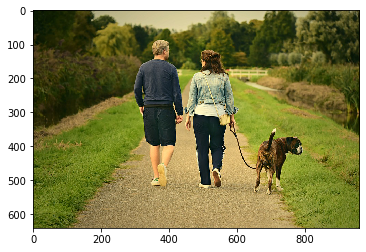

In [45]:
# The name of the image file to annotate
# file_name = 'family.jpg'
file_name = 'test-image3.jpg'

# Loads the image into memory
with io.open(file_name, 'rb') as image_file:
    content = image_file.read()
    print(type(content))


img = plt.imread(file_name)
print(type(img))
plt.imshow(img)
plt.show()

## Object

In [46]:
# help(types.Image)

In [47]:
response = client.object_localization(image=types.Image(content=content)) # Image bytes are required 

ServiceUnavailable: 503 DNS resolution failed

In [10]:
objects = response.localized_object_annotations

In [11]:
objects

[mid: "/m/07mhn"
name: "Pants"
score: 0.9225577712059021
bounding_poly {
  normalized_vertices {
    x: 0.479656845331192
    y: 0.44639864563941956
  }
  normalized_vertices {
    x: 0.5997406840324402
    y: 0.44639864563941956
  }
  normalized_vertices {
    x: 0.5997406840324402
    y: 0.8019291758537292
  }
  normalized_vertices {
    x: 0.479656845331192
    y: 0.8019291758537292
  }
}
, mid: "/m/01bfm9"
name: "Shorts"
score: 0.9119724631309509
bounding_poly {
  normalized_vertices {
    x: 0.3308858573436737
    y: 0.43053290247917175
  }
  normalized_vertices {
    x: 0.4401510953903198
    y: 0.43053290247917175
  }
  normalized_vertices {
    x: 0.4401510953903198
    y: 0.628141462802887
  }
  normalized_vertices {
    x: 0.3308858573436737
    y: 0.628141462802887
  }
}
, mid: "/m/0bt9lr"
name: "Dog"
score: 0.8989588618278503
bounding_poly {
  normalized_vertices {
    x: 0.6729200482368469
    y: 0.5543906092643738
  }
  normalized_vertices {
    x: 0.8244217038154602
    

In [12]:
RAW_CONFIDENCE = 0.9225577712059021

In [13]:
format_confidence(RAW_CONFIDENCE)

92.3

In [14]:
len(objects)

9

In [15]:
for obj in objects:
    print(obj.name.lower(), format_confidence(obj.score))

pants 92.3
shorts 91.2
dog 89.9
woman 86.5
person 84.3
person 81.7
top 74.8
top 69.6
outerwear 61.9


Some helper methods

In [16]:
get_objects(objects)

['outerwear', 'woman', 'dog', 'pants', 'person', 'shorts', 'top']

In [17]:
get_object_confidences(objects, 'person')

[84.3, 81.7]

In [18]:
get_objects_summary(objects)

{'outerwear': 1,
 'woman': 1,
 'dog': 1,
 'pants': 1,
 'person': 2,
 'shorts': 1,
 'top': 2}

## Mock objects
Create a mock objects for testing - generate using a dict and aclass wrapper to allow dot access to dict values from 

In [31]:
MOCK_OBJECT_1 = {"mid": "/m/01g317",
    "name": "Person",
    "score": 0.8431859612464905,
    "bounding_poly" : (
        {"normalized_vertices" : {
            "x": 0.3103858530521393,
            "x": 0.14809174835681915
        }},
        {"normalized_vertices" : {
            "x": 0.460043340921402,
            "y": 0.14809174835681915,
        }},
        {"normalized_vertices" :{
            "x": 0.460043340921402,
            "y": 0.8130884766578674,
        }},
        {"normalized_vertices" :{
        "x": 0.3103858530521393,
        "y": 0.8130884766578674
        }}
    )
    }

In [36]:
MOCK_OBJECT_2 = {"mid": "/m/0bt9lr",
    "name": "Dog",
    "score": 0.9225577712059021,
    "bounding_poly" : (
        {"normalized_vertices" : {
            "x": 0.479656845331192,
            "x": 0.44639864563941956
        }},
        {"normalized_vertices" : {
            "x": 0.5997406840324402,
            "y": 0.44639864563941956,
        }},
        {"normalized_vertices" :{
            "x": 0.5997406840324402,
            "y": 0.8019291758537292,
        }},
        {"normalized_vertices" :{
        "x": 0.479656845331192,
        "y": 0.8019291758537292
        }}
    )
    }

In [37]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [38]:
MOCK_OBJECTS = [dotdict(MOCK_OBJECT_1), dotdict(MOCK_OBJECT_2)]

for obj in MOCK_OBJECTS:
    print(obj.name.lower(), format_confidence(obj.score))

person 84.3
dog 92.3


In [39]:
get_objects(MOCK_OBJECTS)

['dog', 'person']

In [40]:
get_object_confidences(MOCK_OBJECTS, 'person')

[84.3]

In [41]:
get_objects_summary(MOCK_OBJECTS)

{'dog': 1, 'person': 1}

## Bounding boxes

In [16]:
objects[0].bounding_poly.normalized_vertices

[x: 0.479656845331192
y: 0.44639864563941956
, x: 0.5997406840324402
y: 0.44639864563941956
, x: 0.5997406840324402
y: 0.8019291758537292
, x: 0.479656845331192
y: 0.8019291758537292
]

In [17]:
len(objects[0].bounding_poly.normalized_vertices)

4

In [18]:
get_box(objects[0].bounding_poly.normalized_vertices)

[0.4464, 0.47966, 0.80193, 0.59974]

In [19]:
image = Image.open(file_name)
draw = ImageDraw.Draw(image)

img_width, img_height = image.size
print(img_width)
print(img_height)

for obj in objects:
    prediction_confidence = format_confidence(obj.score)
    if obj.name.lower() == TARGET and prediction_confidence >= CONFIDENCE_THRESHOLD:
        box = get_box(obj.bounding_poly.normalized_vertices)
        draw_box(draw, box, img_width, img_height)

960
640


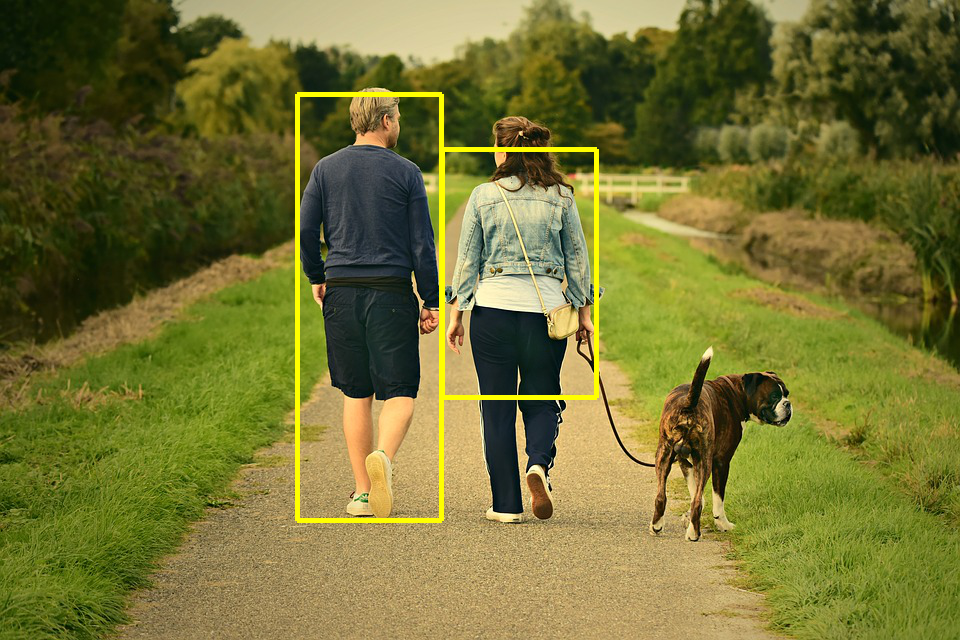

In [20]:
display(image)

## Face

In [21]:
%%time
image = types.Image(content=content)
response = client.face_detection(image=image)
faces = response.face_annotations  

CPU times: user 5.33 ms, sys: 5.32 ms, total: 10.6 ms
Wall time: 528 ms


In [22]:
len(faces)

0

In [23]:
# Names of likelihood from google.cloud.vision.enums
likelihood_name = ('UNKNOWN', 'VERY_UNLIKELY', 'UNLIKELY', 'POSSIBLE',
                       'LIKELY', 'VERY_LIKELY')

print("There are {} faces".format(len(faces)))

print('Faces:')
for face in faces:
    print('anger: {}'.format(likelihood_name[face.anger_likelihood]))
    print('joy: {}'.format(likelihood_name[face.joy_likelihood]))
    print('surprise: {}'.format(likelihood_name[face.surprise_likelihood]))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                for vertex in face.bounding_poly.vertices])

    print('face bounds: {}'.format(','.join(vertices)))

There are 0 faces
Faces:
